In [ ]:
import os
import pandas as pd 
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications import InceptionV3,DenseNet201
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add,BatchNormalization,Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler,ReduceLROnPlateau,ModelCheckpoint
import glob as glob
import seaborn as sns

In [ ]:
img_path='/kaggle/input/flickr8k/Images'
caption_path='/kaggle/input/flickr8k/captions.txt'

In [ ]:
data=pd.read_csv(caption_path)
data.head()

# Text Preprocessing

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    text = " ".join([word for word in text.split() if len(word) > 1 or word in ['a', 'i']])  # Remove short words
    text = "startseq " + text + " endseq"  # Add start and end tokens
    return text

data['caption'] = data['caption'].apply(clean_text)
cleaned_data = data['caption'].to_list()

for i in cleaned_data[:5]:
    print(i)


In [ ]:
data.head()

# Tokenization & Splitting

In [23]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_data)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in cleaned_data)
max_length

37

In [24]:
all_images=data['image'].unique().tolist()
len(all_images)

8091

In [25]:
split_index = round(0.85*len(all_images))

train_images=all_images[:split_index]
val_images=all_images[split_index:]

In [26]:
train=data[data['image'].isin(train_images)]
val=data[data['image'].isin(val_images)]

# Extracting Image features

## Densenet

In [27]:
dense_model = DenseNet201()
dense_model = Model(inputs=dense_model.inputs, outputs=dense_model.layers[-2].output)

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(img_path, image), target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = dense_model.predict(img, verbose=0)
    features[image] = feature  

# Data Setup

In [31]:
class datasetgenerator(Sequence):
    def __init__(self,data,x_col,y_col,batch_size,tokenizer,vocab_size,max_length,features,shuffle=True):
        self.data = data.copy()
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.data)

    def on_epoch(self): #Shuffles the data after each epoch 
        if self.shufle:
            self.data=self.data.sample(frac=1).reset_index(drop=True)
            
    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):
        batch=self.data.iloc[index*self.batch_size:(index+1)*self.batch_size,:]
        x1,x2,y=self.__get_data(batch) #X1: Image features X2: Input sequence (caption so far) y: Target word (next word in the caption)
        return (x1,x2),y

    def __get_data(self,batch):
        x1,x2,y=[],[],[]
        images=batch[self.x_col].tolist() #Extracted image names
        
        for img in images:
            feature=self.features[img][0] #features of the image
            captions=batch.loc[batch[self.x_col]==img,self.y_col].tolist() #Captions for the image
            
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(len(seq)):
                    in_seq,out_seq= seq[:i],seq[i]
                    in_seq= pad_sequences([in_seq],maxlen=self.max_length,)[0]
                    out_seq= to_categorical([out_seq],num_classes=self.vocab_size)[0]
                    x1.append(feature)
                    x2.append(in_seq)
                    y.append(out_seq)
        return np.array(x1), np.array(x2), np.array(y)

In [32]:
batch_size=64
train_data_generator=datasetgenerator(train,'image','caption',batch_size,tokenizer,vocab_size,max_length,features)
val_data_generator=datasetgenerator(val,'image','caption',batch_size,tokenizer,vocab_size,max_length,features)

# Build The Model

In [34]:
import gensim
from gensim.models import KeyedVectors

# Load FastText vectors (replace path with the actual .vec or .bin file path)
fasttext = KeyedVectors.load_word2vec_format('/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec', binary=False)

In [35]:
embedding_dim = 300  # because FastText vectors are 300-dimensional
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in fasttext:
        embedding_matrix[i] = fasttext[word]
    else:
        # For unknown words, you can leave them as zeros or use a random vector
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))


In [ ]:
def build_model(vocab_size, max_length, embedding_matrix, embedding_dim=300):
    # Encoder
    Input_image = Input(shape=(1920,), name='Feature_Input')  # Flattened shape
    x = BatchNormalization()(Input_image)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Decoder
    Input_cation = Input(shape=(max_length,), name='Caption_Input')
    y = Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=max_length,
              trainable=True)(Input_cation) 

    y = LSTM(256,return_sequences=True,)(y)
    y = LSTM(256)(y)
    
    # Output
    decoder = add([x, y])
    decoder = Dense(256, activation='relu')(decoder)
    output = Dense(vocab_size, activation='softmax', name='output_layer')(decoder)
    
    # Create the model
    model = Model(inputs=[Input_image, Input_cation], outputs=output)
    return model

In [37]:
model = build_model(vocab_size, max_length, embedding_matrix)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Feature_Input             │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Caption_Input             │ (None, 37)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1920)           │          7,680 │ Feature_Input[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 37, 300)        │      2,643,900 │ Caption_Input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        491,776 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 37, 256)        │        570,368 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ batch_normalization_1… │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 8813)           │      2,264,941 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,570,793 (25.07 MB)

 Trainable params: 6,566,441 (25.05 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4) #weight_decay: A technique that penalizes large weights by adding an L2 penalty term to the loss.To prevent overfitting by keeping the model weights small and simple.
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# Training

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_schedul=ReduceLROnPlateau(monitor='val_loss', 
                             patience=3, 
                             verbose=1, 
                             factor=0.2, 
                             min_lr=0.00000001)
model_name = "model.keras"

checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

history = model.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=50,
    callbacks=[early_stopping,lr_schedul,checkpoint]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 4.9335 
Epoch 1: val_loss improved from inf to 3.48649, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 6802s 13s/step - loss: 4.9321 - val_loss: 3.4865 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 3.2192 
Epoch 2: val_loss improved from 3.48649 to 3.20484, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 6765s 13s/step - loss: 3.2191 - val_loss: 3.2048 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 2.7879 
Epoch 3: val_loss improved from 3.20484 to 3.10017, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 6750s 13s/step - loss: 2.7879 - val_loss: 3.1002 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 2.4812 
Epoch 4: val_loss did not improve from 3.10017
537/537 ━━━━━━━━━━━━━━━━━━━━ 6737s 13s/step - loss: 2.4812 - val_loss: 3.1320 - learning_rate: 0.0010
Epoch 5/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/s

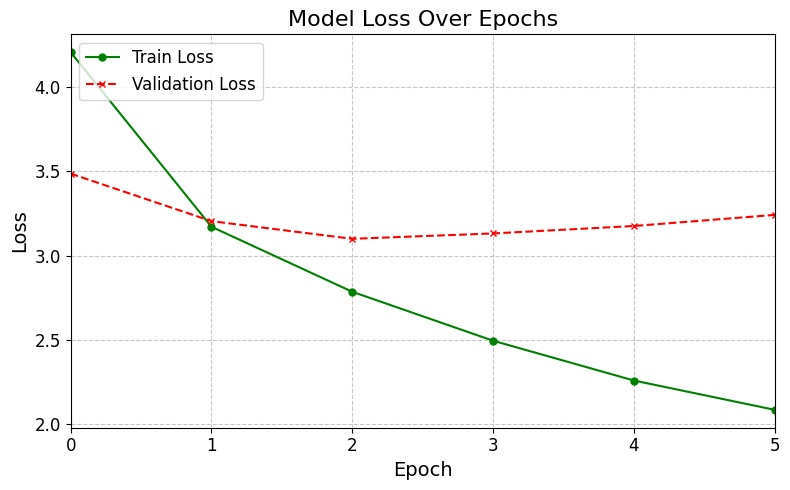

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()


# Generate Caption

In [70]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [71]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text

In [72]:
samples = val.sample(15)
samples.reset_index(drop=True,inplace=True)

In [75]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(img_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [76]:
from textwrap import wrap

def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i].replace('startseq',"").replace("endseq",""), 20)))
        plt.axis("off")

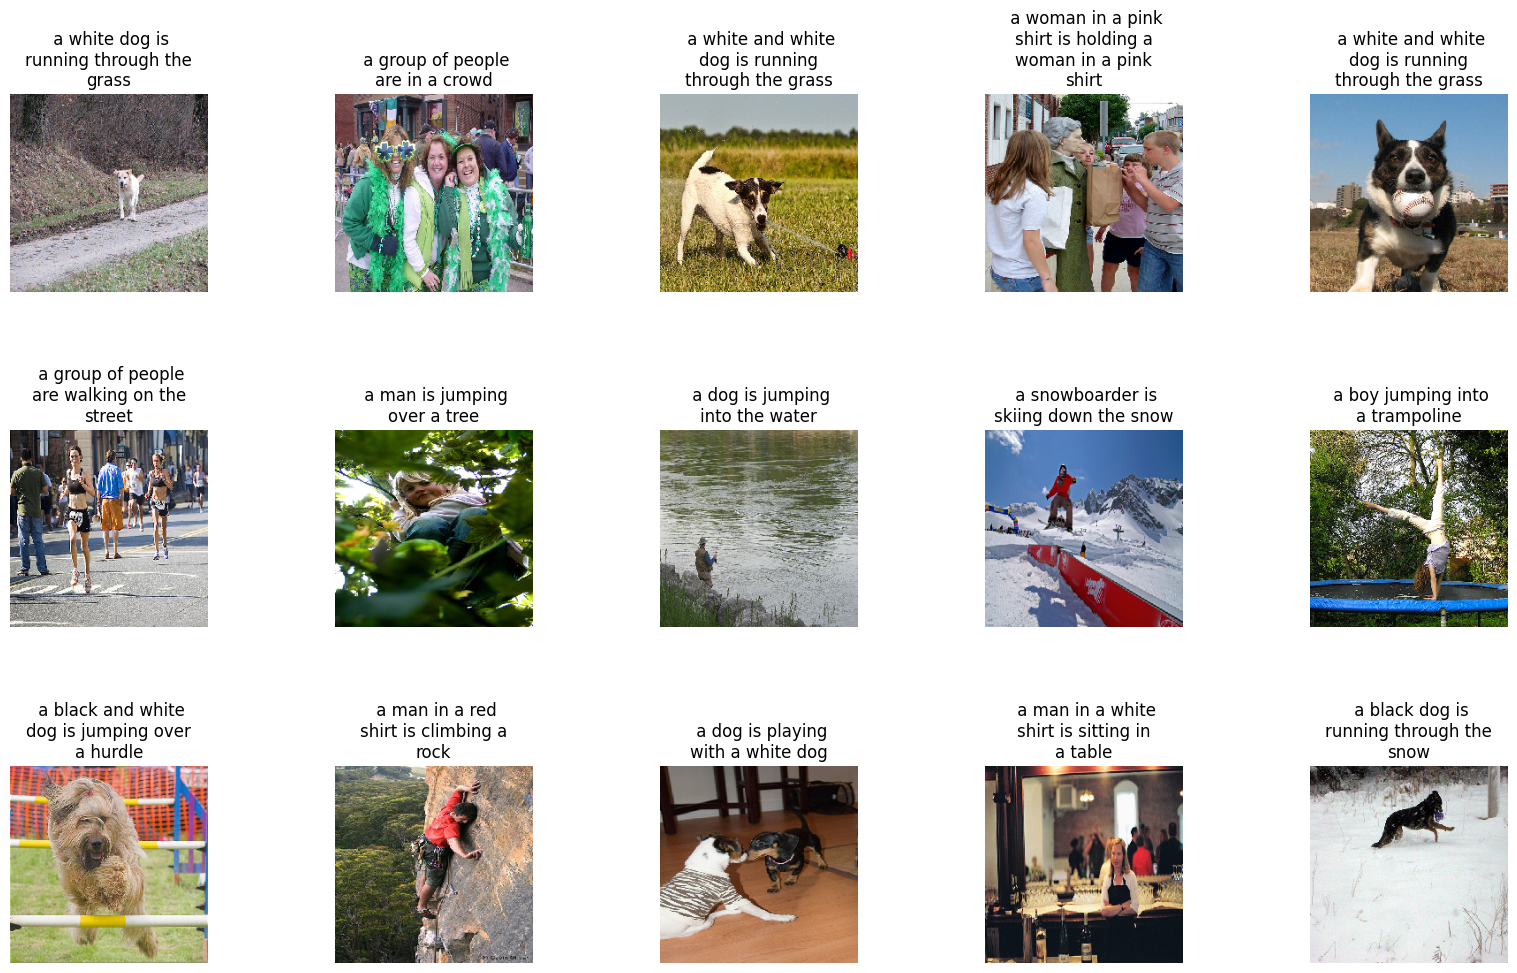

In [77]:
display_images(samples)